In [1]:
import identification_py2 as ident_tools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import control as con
import glob #for returning files having the specified path extension
import statistics as stats
import os #checking for empty file
%pylab inline

from sysident import loadtools

Populating the interactive namespace from numpy and matplotlib


###### Passing all the data into arrays 

In [2]:
task_first        = sorted(glob.glob('step_log_new/*/*task*.log')) #corresponds to .log files that has data related to the first position
control_first     = sorted(glob.glob('step_log_new/*/*control*.log'))
task_remaining    = sorted(glob.glob('step_log_new/*/*task*.log.*')) #corresponds to remaining log.'n' files
control_remaining = sorted(glob.glob('step_log_new/*/*control*.log.*'))
task              = sorted(task_first + task_remaining) #set of all task_velocity logs
control           = sorted(control_first + control_remaining) #set of all control logs
observations      = len(task_first) #total number of experiments conducted/observations taken
positions         = int(len(task) / observations) #number of points in the given task space
task_full         = [] #A task_velocity list whose each element is a list of similar log files i.e from the same position
control_full      = [] #A control_output list whose each element is a list of similar log files i.e from the same position

for i in range(0, positions):
    task_full.append([])
    control_full.append([])
    for j in range(0, observations):
        task_full[i].append(task[i + (j * positions)])
        control_full[i].append(control[i + (j * positions)])

count = 0 #counter that returns the number of empty files
for i in range(0, positions):
    for j in range(0, observations):
        if os.stat(task_full[i][j]).st_size == 0:
            count = count + 1
            
for i in range(0, positions):
    for j in range(0, observations-count):
        if os.stat(task_full[i][j]).st_size == 0:
            del(task_full[i][j])
            del(control_full[i][j])
            
# Reading all the data into a dataframe array
df_ist_soll = []
model_estimations = []

for i in range(0, positions):
    df_ist_soll.append([])
    model_estimations.append([])
    for j in range(0, observations):
        try:
            # initialize result dictionary
            model_estimations[i].append({})
            df_ist_soll[i].append(ident_tools.batch_read_data(control_full[i][j], task_full[i][j]))
        except:
            print "Some Error occured and was ignored"
            continue
            
print "############################### INFO #########################################"
print "df_ist_soll contains all reference and actual data per each position and each experiement"
print
print "df_ist_soll[position][experiement] -> pandas.Dataframe{'x_ist', 'x_soll'}"
print "model_estimations[position][experiement] -> dict{'delay', 'scale_factor', ...}"
print "############################### INFO #########################################"


############################### INFO #########################################
df_ist_soll contains all reference and actual data per each position and each experiement

df_ist_soll[position][experiement] -> pandas.Dataframe{'x_ist', 'x_soll'}
model_estimations[position][experiement] -> dict{'delay', 'scale_factor', ...}
############################### INFO #########################################


###### Cut away leading zeros -> starts directly with step!

In [3]:
for i, df_pos in enumerate(df_ist_soll):
    for j, df_exp in enumerate(df_pos):

        df_shifted = df_exp.loc[df_exp.x_soll != 0.0]
        df_shifted.index = df_shifted.index - df_shifted.index[0]

        df_ist_soll[i][j] = df_shifted


###### Resample to equal time distances

In [4]:
for i, df_pos in enumerate(df_ist_soll):
    for j, df_exp in enumerate(df_pos):

        #print df_exp.head()
        #print df_exp.tail()
        #ax0 = df_exp.plot()

        # Convert to pandas timeseries 
        df_ist_soll[i][j].set_index(pd.to_datetime(df_ist_soll[i][j].index, unit='s'), inplace=True)
        #ax = df_exp.plot()
        #print df_exp.head()

        # Resample pad and fill NaNs
        df_ist_soll[i][j] = df_ist_soll[i][j].resample('1ms').pad().bfill()
        #df_exp.plot(ax=ax)

        #print df_exp.head()
        #print df_exp.tail()

        # Revert so numerical format index
        #df_exp['datetime'] = df_exp.index
        df_ist_soll[i][j]['time'] = pd.to_numeric(df_ist_soll[i][j].index, downcast='float')/1e9
        df_ist_soll[i][j].set_index('time', inplace=True)

        #df_exp.plot(ax=ax0)
        #print df_ist_soll[0][0].head()

###### Displaying all the observations

###### Smoothing using Savgol filter and normalization of data

In [5]:
for i, df_pos in enumerate(df_ist_soll):
    for j, df_exp in enumerate(df_pos):
        
        # The following expects the unit step to be single and alone per experiement!
        if len(df_exp.x_soll.value_counts()) > 2:
            print "WARNING! - Data in Position {0}, Experiement {1} (df_ist_soll[{0}][{1}])".format(i, j)
            print "has more than {} different values". format(len(df_exp.x_soll.value_counts()))
            print "!!!! This could lead to wrong calculations!!!!"
            print "!!!! Target values should be either Zero (beginning) or step height (until end)!!!!"
            print df_exp.x_soll.value_counts()

        factor = 1.0/max(df_exp.x_soll)
        model_estimations[i][j]['step_height'] = max(df_exp.x_soll)
        model_estimations[i][j]['scale_factor'] = factor
        df_ist_soll[i][j] = pd.concat(
            [df_ist_soll[i][j],
            pd.DataFrame(
                factor*np.array(df_exp.x_ist),
                columns=['normalized'],
                index=df_exp.index)],
            axis=1)
        
        for order in range(1, 4):
            df_ist_soll[i][j] = pd.concat(
                [df_ist_soll[i][j],
                pd.DataFrame(
                    ident_tools.smooth(factor*np.array(df_exp.x_ist), order),
                    columns=['smooth_{}'.format(order)],
                    index=df_exp.index)],
                axis=1)

       x_soll         x_ist  normalized  smooth_1  smooth_2  smooth_3
time                                                                 
0.000     0.1  8.052671e-07    0.000008  0.000008  0.000008  0.000008
0.001     0.1  7.068506e-07    0.000007  0.000007  0.000007  0.000007
0.002     0.1  7.068506e-07    0.000007  0.000007  0.000007  0.000007
0.003     0.1  7.068506e-07    0.000007  0.000007  0.000007  0.000007
0.004     0.1  7.068506e-07    0.000007  0.000007  0.000007  0.000007
{'step_height': 0.1, 'scale_factor': 10.0}
Index([u'normalized', u'smooth_1', u'smooth_2', u'smooth_3'], dtype='object')


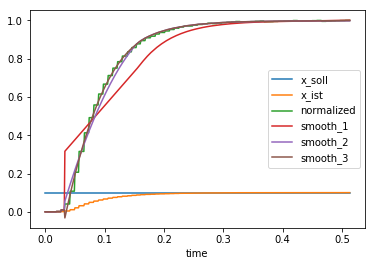

In [6]:
df_ist_soll[0][0].plot()
print df_ist_soll[0][0].head()

print model_estimations[0][0]
print df_ist_soll[0][0].keys()[2:]

###### PT1 + PT2 Estimation 

In [7]:
for i, df_pos in enumerate(df_ist_soll):
    for j, df_exp in enumerate(df_pos):
        
        for order in range(1,4):
            # PT1 Estimations
            tf, _, _, delay, time_constant, steady_state, tf_without_delay =\
                ident_tools.pt1(np.array(df_exp['smooth_{}'.format(order)]), np.array(df_exp.index))
            pt1_dict = {
                'tf_delay': tf,
                'tf': tf_without_delay,
                'delay': delay,
                'time_constant': time_constant,
                'steady_state': steady_state
            }
            model_estimations[i][j]['pt1_smooth_{}'.format(order)] = pt1_dict
        
        for order in range(1,4):
            try:
                tf, _, _, delay, time_constant, steady_state, zeta, tf_without_delay =\
                    ident_tools.pt2(np.array(df_exp['smooth_{}'.format(order)]), np.array(df_exp.index))

                pt2_dict = {
                    'tf_delay': tf,
                    'tf': tf_without_delay,
                    'delay': delay,
                    'time_constant': time_constant,
                    'steady_state': steady_state,
                    'zeta': zeta,
                }
                model_estimations[i][j]['pt2_smooth_{}'.format(order)] = pt2_dict
            except:
                print "PT2 Estimation failed (smoothed_{2})! Position {0}, Experiement {1}; df_ist_soll[{0}][{1}]".format(i, j, order)
                #model_estimations[i][j]['pt2_smooth_{}'.format(order)] = None

        try:
            tf, _, _, delay, time_constant, steady_state, zeta, tf_without_delay =\
                ident_tools.pt2(np.array(df_exp['normalized']), np.array(df_exp.index))

            pt2_dict = {
                'tf_delay': tf,
                'tf': tf_without_delay,
                'delay': delay,
                'time_constant': time_constant,
                'steady_state': steady_state,
                'zeta': zeta,
            }
            model_estimations[i][j]['pt2'] = pt2_dict
        except:
            print "PT2 Estimation failed (normalized)! Position {0}, Experiement {1}; df_ist_soll[{0}][{1}]".format(i, j)
            #model_estimations[i][j]['pt2'] = None

PT2 Estimation failed (smoothed_1)! Position 0, Experiement 0; df_ist_soll[0][0]


identification_py2.py:288: RuntimeWarning: divide by zero encountered in log
  zeta = np.sqrt((np.log(overshoot) ** 2) / ((np.pi ** 2) + (np.log(overshoot) ** 2)))
identification_py2.py:288: RuntimeWarning: invalid value encountered in double_scalars
  zeta = np.sqrt((np.log(overshoot) ** 2) / ((np.pi ** 2) + (np.log(overshoot) ** 2)))


PT2 Estimation failed (smoothed_3)! Position 0, Experiement 0; df_ist_soll[0][0]
PT2 Estimation failed (normalized)! Position 0, Experiement 0; df_ist_soll[0][0]
PT2 Estimation failed (smoothed_1)! Position 0, Experiement 1; df_ist_soll[0][1]
PT2 Estimation failed (smoothed_3)! Position 0, Experiement 1; df_ist_soll[0][1]
PT2 Estimation failed (normalized)! Position 0, Experiement 1; df_ist_soll[0][1]
PT2 Estimation failed (smoothed_1)! Position 0, Experiement 2; df_ist_soll[0][2]
PT2 Estimation failed (smoothed_3)! Position 0, Experiement 2; df_ist_soll[0][2]
PT2 Estimation failed (smoothed_1)! Position 0, Experiement 3; df_ist_soll[0][3]
PT2 Estimation failed (smoothed_3)! Position 0, Experiement 3; df_ist_soll[0][3]
PT2 Estimation failed (smoothed_1)! Position 0, Experiement 4; df_ist_soll[0][4]
PT2 Estimation failed (smoothed_3)! Position 0, Experiement 4; df_ist_soll[0][4]
PT2 Estimation failed (smoothed_1)! Position 0, Experiement 5; df_ist_soll[0][5]
PT2 Estimation failed (smoot

PT2 Estimation failed (smoothed_1)! Position 5, Experiement 3; df_ist_soll[5][3]
PT2 Estimation failed (smoothed_3)! Position 5, Experiement 3; df_ist_soll[5][3]
PT2 Estimation failed (normalized)! Position 5, Experiement 3; df_ist_soll[5][3]
PT2 Estimation failed (smoothed_1)! Position 5, Experiement 4; df_ist_soll[5][4]
PT2 Estimation failed (smoothed_3)! Position 5, Experiement 4; df_ist_soll[5][4]
PT2 Estimation failed (normalized)! Position 5, Experiement 4; df_ist_soll[5][4]
PT2 Estimation failed (smoothed_1)! Position 5, Experiement 5; df_ist_soll[5][5]
PT2 Estimation failed (smoothed_3)! Position 5, Experiement 5; df_ist_soll[5][5]
PT2 Estimation failed (smoothed_1)! Position 5, Experiement 6; df_ist_soll[5][6]
PT2 Estimation failed (smoothed_3)! Position 5, Experiement 6; df_ist_soll[5][6]
PT2 Estimation failed (smoothed_1)! Position 5, Experiement 7; df_ist_soll[5][7]
PT2 Estimation failed (smoothed_3)! Position 5, Experiement 7; df_ist_soll[5][7]
PT2 Estimation failed (smoot

['pt1_smooth_3', 'pt1_smooth_2', 'pt1_smooth_1', 'step_height', 'pt2_smooth_2', 'scale_factor']
['steady_state', 'delay', 'tf', 'zeta', 'time_constant', 'tf_delay']


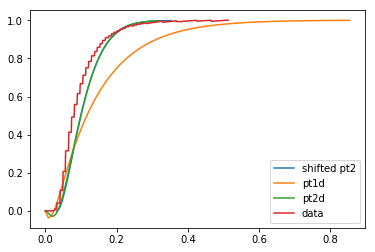

In [8]:
print model_estimations[0][0].keys()
print model_estimations[0][0]['pt2_smooth_2'].keys()

t0, y0 = con.step_response(model_estimations[0][0]['pt2_smooth_2']['tf'])
t1, y1 = con.step_response(model_estimations[0][0]['pt1_smooth_1']['tf_delay'])
t2, y2 = con.step_response(model_estimations[0][0]['pt2_smooth_2']['tf_delay'])

### Plotting
plot(t0+model_estimations[0][0]['pt2_smooth_2']['delay'], y0, label='shifted pt2')
#plot(t0, y0, label='unshifted pt2')
plot(t1, y1, label='pt1d')
plot(t2, y2, label='pt2d')
plot(df_ist_soll[0][0]['normalized'], label='data')
plt.legend()

In [9]:
# TODO:
# Average values over position and experiement 

In [10]:
from sklearn.metrics import mean_squared_error
def get_mse(y, t, df_ist_soll):
    try:
        df_sysout = pd.DataFrame(y, index=pd.to_datetime(t, unit='s'))
        df_sysout = df_sysout.drop_duplicates(df_sysout.index)
        df_sysout = df_sysout.resample('1ms').pad().bfill()
        df_sysout['time'] = pd.to_numeric(df_sysout.index, downcast='float')/1e9
        df_sysout.set_index('time', inplace=True)

        # This is probably not needed anymore, since it is all reshaped at the beginning
        df_shifted = df_ist_soll.loc[df_ist_soll.x_soll != 0.0]
        df_shifted.index = df_shifted.index - df_shifted.index[0]

        df_concat = pd.concat([df_sysout,
                               df_shifted],
                              axis=1, join='inner', ignore_index=False)

        mse = mean_squared_error(df_concat.normalized.values, df_concat[0].values)
        #assert (mse == np.mean(np.square(df_concat[0]-df_concat.normalized))) # Just to understand what is going on
        
    except ValueError as e:
        print "Exception"
        print e
        #plot(y, t)
        #df_sysout.plot()
        mse = 1.0
        
    ## Test Tonys impl
    try:
        mse_tony = 1.0
        #mse_tony = ident_tools.mse(df_ist_soll.normalized.values,
        #                           df_ist_soll.index.values,
        #                           y,
        #                           t)
    except ValueError as e:
        print "Exception"
        print e
        mse_tony = 1.0

    return mse, mse_tony

In [11]:
m1, m2 = get_mse(y1, t1, df_ist_soll[0][0])



In [12]:
for i, df_pos in enumerate(df_ist_soll):
    for j, df_exp in enumerate(df_pos):
        for key in model_estimations[i][j].keys():
            if key in ['step_height', 'scale_factor']:
                #skip
                continue
            print "Processing MSE for Experiement[{0}][{1}][{2}]".format(i,j, key)
            t, y = con.step_response(model_estimations[i][j][key]['tf_delay'])
            model_estimations[i][j][key]['y_step'] = pd.DataFrame({'time': t, 'y_step': y}).set_index('time')            

            mse, mse_tony = get_mse(y, t, df_exp)
            model_estimations[i][j][key]['mse'] = mse            
            model_estimations[i][j][key]['mse_tony'] = mse_tony

Processing MSE for Experiement[0][0][pt1_smooth_3]
Processing MSE for Experiement[0][0][pt1_smooth_2]
Processing MSE for Experiement[0][0][pt1_smooth_1]
Processing MSE for Experiement[0][0][pt2_smooth_2]
Processing MSE for Experiement[0][1][pt1_smooth_3]
Processing MSE for Experiement[0][1][pt1_smooth_2]
Processing MSE for Experiement[0][1][pt1_smooth_1]
Processing MSE for Experiement[0][1][pt2_smooth_2]
Processing MSE for Experiement[0][2][pt1_smooth_3]
Processing MSE for Experiement[0][2][pt1_smooth_2]
Processing MSE for Experiement[0][2][pt1_smooth_1]
Processing MSE for Experiement[0][2][pt2_smooth_2]
Processing MSE for Experiement[0][2][pt2]
Processing MSE for Experiement[0][3][pt1_smooth_3]
Processing MSE for Experiement[0][3][pt1_smooth_2]
Processing MSE for Experiement[0][3][pt1_smooth_1]
Processing MSE for Experiement[0][3][pt2_smooth_2]
Processing MSE for Experiement[0][3][pt2]
Processing MSE for Experiement[0][4][pt1_smooth_3]
Processing MSE for Experiement[0][4][pt1_smooth_2

Processing MSE for Experiement[3][6][pt1_smooth_1]
Processing MSE for Experiement[3][6][pt2_smooth_2]
Processing MSE for Experiement[3][6][pt2]
Processing MSE for Experiement[3][7][pt1_smooth_3]
Processing MSE for Experiement[3][7][pt1_smooth_2]
Processing MSE for Experiement[3][7][pt1_smooth_1]
Processing MSE for Experiement[3][7][pt2_smooth_3]
Processing MSE for Experiement[3][7][pt2_smooth_2]
Processing MSE for Experiement[3][7][pt2]
Processing MSE for Experiement[3][8][pt1_smooth_3]
Processing MSE for Experiement[3][8][pt1_smooth_2]
Processing MSE for Experiement[3][8][pt1_smooth_1]
Processing MSE for Experiement[3][8][pt2_smooth_2]
Processing MSE for Experiement[3][8][pt2]
Processing MSE for Experiement[3][9][pt1_smooth_3]
Processing MSE for Experiement[3][9][pt1_smooth_2]
Processing MSE for Experiement[3][9][pt1_smooth_1]
Processing MSE for Experiement[3][9][pt2_smooth_2]
Processing MSE for Experiement[3][9][pt2]
Processing MSE for Experiement[4][0][pt1_smooth_3]
Processing MSE f

Processing MSE for Experiement[7][0][pt1_smooth_2]
Processing MSE for Experiement[7][0][pt1_smooth_1]
Processing MSE for Experiement[7][0][pt2_smooth_2]
Processing MSE for Experiement[7][0][pt2]
Processing MSE for Experiement[7][1][pt1_smooth_3]
Processing MSE for Experiement[7][1][pt1_smooth_2]
Processing MSE for Experiement[7][1][pt1_smooth_1]
Processing MSE for Experiement[7][1][pt2_smooth_2]
Processing MSE for Experiement[7][2][pt1_smooth_3]
Processing MSE for Experiement[7][2][pt1_smooth_2]
Processing MSE for Experiement[7][2][pt1_smooth_1]
Processing MSE for Experiement[7][2][pt2_smooth_2]
Processing MSE for Experiement[7][2][pt2]
Processing MSE for Experiement[7][3][pt1_smooth_3]
Processing MSE for Experiement[7][3][pt1_smooth_2]
Processing MSE for Experiement[7][3][pt1_smooth_1]
Processing MSE for Experiement[7][3][pt2_smooth_2]
Processing MSE for Experiement[7][4][pt1_smooth_3]
Processing MSE for Experiement[7][4][pt1_smooth_2]
Processing MSE for Experiement[7][4][pt1_smooth_1

In [13]:
def results_from_all_experiements_in_position(pos, est_sys_key, paramerter_key):
    res = []
    for j, exp in enumerate(model_estimations[pos]):
        if est_sys_key in model_estimations[pos][j]:
            res.append(model_estimations[pos][j][est_sys_key][paramerter_key])
    return res

def from_every_experiement(est_sys_key, paramerter_key):
    res = []
    for i, pos in enumerate(model_estimations):
        for j, exp in enumerate(pos):
            if est_sys_key in pos[j]:
                res.append(exp[est_sys_key][paramerter_key])
    return res

def experiement_by_value(parameter_key):
    result = []
    position = []
    for i, pos in enumerate(model_estimations):
        for j, exp in enumerate(pos):
            #print exp.keys()
            for k, variant in enumerate(exp):
                #print exp[variant]
                if type(exp[variant]) is dict and parameter_key in exp[variant].keys():
                    result.append(exp[variant][parameter_key])
                    position.append( (i, j, variant, parameter_key) )
    return result, position

#print results_from_all_experiements_in_position(0, 'pt1_smooth_2', 'steady_state')
#print
#print from_every_experiement('pt1_smooth_2', 'steady_state')

In [ ]:
#print from_every_experiement('pt1_smooth_1', 'mse')
#print from_every_experiement('pt1_smooth_2', 'mse')
#print from_every_experiement('pt1_smooth_3', 'mse')
#print experiement_by_value('mse')

In [ ]:
# Processing MSE against all data and average!
# Get all step_responses
res, pos = experiement_by_value('y_step') 

for df_step, (ii, jj, variant, _) in zip(res, pos):
    print "Processing", ii, jj, variant
    mse = model_estimations[ii][jj][variant]['mse']
    
    for i, df_pos in enumerate(df_ist_soll):
        #print i
        for j, df_exp in enumerate(df_pos):
            #print j
            if ii != i and jj != j:
                #print df_step.y_step.values
                _mse, _mse_tony = get_mse(df_step.y_step.values, df_step.index.values, df_exp)
                mse = mse + _mse

    mse = mse /(observations*positions)
    model_estimations[ii][jj][variant]['mse_avg'] = mse

Processing 0 0 pt1_smooth_3
Processing 0 0 pt1_smooth_2
Processing 0 0 pt1_smooth_1
Processing 0 0 pt2_smooth_2
Processing 0 1 pt1_smooth_3
Processing 0 1 pt1_smooth_2
Processing 0 1 pt1_smooth_1
Processing 0 1 pt2_smooth_2
Processing 0 2 pt1_smooth_3
Processing 0 2 pt1_smooth_2
Processing 0 2 pt1_smooth_1
Processing 0 2 pt2_smooth_2
Processing 0 2 pt2
Processing 0 3 pt1_smooth_3
Processing 0 3 pt1_smooth_2
Processing 0 3 pt1_smooth_1
Processing 0 3 pt2_smooth_2
Processing 0 3 pt2
Processing 0 4 pt1_smooth_3
Processing 0 4 pt1_smooth_2
Processing 0 4 pt1_smooth_1
Processing 0 4 pt2_smooth_2
Processing 0 4 pt2
Processing 0 5 pt1_smooth_3
Processing 0 5 pt1_smooth_2
Processing 0 5 pt1_smooth_1
Processing 0 5 pt2_smooth_2
Processing 0 5 pt2
Processing 0 6 pt1_smooth_3
Processing 0 6 pt1_smooth_2
Processing 0 6 pt1_smooth_1
Processing 0 6 pt2_smooth_3
Processing 0 6 pt2_smooth_2
Processing 0 6 pt2
Processing 0 7 pt1_smooth_3
Processing 0 7 pt1_smooth_2
Processing 0 7 pt1_smooth_1
Processin

Processing 6 2 pt1_smooth_2
Processing 6 2 pt1_smooth_1
Processing 6 2 pt2_smooth_2
Processing 6 3 pt1_smooth_3
Processing 6 3 pt1_smooth_2
Processing 6 3 pt1_smooth_1
Processing 6 3 pt2_smooth_2
Processing 6 3 pt2_smooth_1
Processing 6 3 pt2
Processing 6 4 pt1_smooth_3
Processing 6 4 pt1_smooth_2
Processing 6 4 pt1_smooth_1
Processing 6 4 pt2_smooth_2
Processing 6 4 pt2
Processing 6 5 pt1_smooth_3
Processing 6 5 pt1_smooth_2
Processing 6 5 pt1_smooth_1
Processing 6 5 pt2_smooth_2
Processing 6 6 pt1_smooth_3
Processing 6 6 pt1_smooth_2
Processing 6 6 pt1_smooth_1
Processing 6 6 pt2_smooth_2
Processing 6 6 pt2
Processing 6 7 pt1_smooth_3
Processing 6 7 pt1_smooth_2
Processing 6 7 pt1_smooth_1
Processing 6 7 pt2_smooth_2
Processing 6 7 pt2
Processing 6 8 pt1_smooth_3
Processing 6 8 pt1_smooth_2
Processing 6 8 pt1_smooth_1
Processing 6 8 pt2_smooth_3
Processing 6 8 pt2_smooth_2
Processing 6 8 pt2
Processing 6 9 pt1_smooth_3
Processing 6 9 pt1_smooth_2
Processing 6 9 pt1_smooth_1
Processin

In [ ]:
res, pos = experiement_by_value('mse_avg')
i, j, var, _ = pos[res.index(min(res))]
print "All time Best", min(res), pos[res.index(min(res))]

ax = model_estimations[i][j][var]['y_step'].plot()
df_ist_soll[8][6]['normalized'].plot(ax=ax)

print model_estimations[i][j][var]['tf_delay']
print "Poles:\n", model_estimations[i][j][var]['tf_delay'].pole()
print "Zeros:\n", model_estimations[i][j][var]['tf_delay'].zero()
print
print "SS (without delay):\n", con.tf2ss(model_estimations[i][j][var]['tf'])
print "delay [s]:", model_estimations[i][j][var]['delay']
print "SS (with delay):\n", con.tf2ss(model_estimations[i][j][var]['tf_delay'])

plt.axvline(x=model_estimations[i][j][var]['delay'], color='black')


poles = con.pole(model_estimations[i][j][var]['tf_delay'])

fname = '{}_poles{}_ident_{}'.format(time.strftime("%Y%m%d-%H%M%S"),
                                    len(poles), 'pade1_{}'.format(model_estimations[i][j][var]['delay']).replace('.', ':'))

_ss = con.tf2ss(model_estimations[i][j][var]['tf_delay'])
loadtools.saveModel(fname, _ss.A, _ss.B, _ss.C, _ss.D)
loadtools.saveNPY(fname, delay=model_estimations[i][j][var]['delay'])


poles = con.pole(model_estimations[i][j][var]['tf'])

fname = '{}_poles{}_ident_{}'.format(time.strftime("%Y%m%d-%H%M%S"),
                                    len(poles), 'nodelay')

_ss = con.tf2ss(model_estimations[i][j][var]['tf'])
loadtools.saveModel(fname, _ss.A, _ss.B, _ss.C, _ss.D)
loadtools.saveNPY(fname, delay=model_estimations[i][j][var]['delay'])


#i, j, var, _ = pos[res.index(max(res))]
#print "Worst", max(res), pos[res.index(max(res))]
#model_estimations[i][j][var]['y_step'].plot(ax=ax)

In [ ]:
res, pos = experiement_by_value('mse_avg')
i, j, var, _ = pos[res.index(min(res))]
print "All time Best", min(res), pos[res.index(min(res))]

#ax = model_estimations[i][j][var]['y_step'].plot()

###########################################
pade_cnt = 2

###########################################

tf = model_estimations[i][j][var]['tf']

numerator, denominator = con.pade(delay, pade_cnt)
delay2_tf           = con.tf(numerator,denominator)

tf_delay2 = tf * delay2_tf

df_ist_soll[8][6]['normalized'].plot()
plt.plot(*con.step_response(tf_delay2))

print "Poles:\n", tf_delay2.pole()
print "Zeros:\n", tf_delay2.zero()
print
print "SS (without delay):\n", con.tf2ss(model_estimations[i][j][var]['tf'])
print "delay [s]:", model_estimations[i][j][var]['delay']
print "SS (with delay):\n", con.tf2ss(tf_delay2)

plt.axvline(x=model_estimations[i][j][var]['delay'], color='black')


poles = con.pole(tf_delay2)

fname = '{}_poles{}_ident_{}'.format(time.strftime("%Y%m%d-%H%M%S"),
                                    len(poles), 'pade{}_{}'.format(pade_cnt, model_estimations[i][j][var]['delay']).replace('.', ':'))

_ss = con.tf2ss(tf_delay2)
loadtools.saveModel(fname, _ss.A, _ss.B, _ss.C, _ss.D)
loadtools.saveNPY(fname, delay=model_estimations[i][j][var]['delay'])


poles = con.pole(model_estimations[i][j][var]['tf'])

fname = '{}_poles{}_ident_{}'.format(time.strftime("%Y%m%d-%H%M%S"),
                                    len(poles), 'nodelay')

_ss = con.tf2ss(model_estimations[i][j][var]['tf'])
loadtools.saveModel(fname, _ss.A, _ss.B, _ss.C, _ss.D)
loadtools.saveNPY(fname, delay=model_estimations[i][j][var]['delay'])


#i, j, var, _ = pos[res.index(max(res))]
#print "Worst", max(res), pos[res.index(max(res))]
#model_estimations[i][j][var]['y_step'].plot(ax=ax)

In [ ]:
res, pos = experiement_by_value('mse_avg')
# Clean up unwanted stuff

wanted_key = 'pt1'

idx = []
for p, r in zip(pos, res):
    for key in p:
        if wanted_key in str(key):
            idx.append(pos.index(p))

clean_res = [res[i] for i in idx]
clean_pos = [pos[i] for i in idx]

pos = clean_pos
res = clean_res

###########################################################

i, j, var, _ = pos[res.index(min(res))]
print "Best {}:".format(wanted_key), min(res), pos[res.index(min(res))]

###########################################
pade_cnt = 2

###########################################

tf = model_estimations[i][j][var]['tf']

numerator, denominator = con.pade(delay, pade_cnt)
delay2_tf           = con.tf(numerator,denominator)

tf_delay2 = tf * delay2_tf

df_ist_soll[8][6]['normalized'].plot()
plt.plot(*con.step_response(tf_delay2))

print "Poles:\n", tf_delay2.pole()
print "Zeros:\n", tf_delay2.zero()
print
print "SS (without delay):\n", con.tf2ss(model_estimations[i][j][var]['tf'])
print "delay [s]:", model_estimations[i][j][var]['delay']
print "SS (with delay):\n", con.tf2ss(tf_delay2)

plt.axvline(x=model_estimations[i][j][var]['delay'], color='black')


poles = con.pole(tf_delay2)

fname = '{}_poles{}_ident_{}'.format(time.strftime("%Y%m%d-%H%M%S"),
                                    len(poles), 'pade{}_{}'.format(pade_cnt, model_estimations[i][j][var]['delay']).replace('.', ':'))

_ss = con.tf2ss(tf_delay2)
loadtools.saveModel(fname, _ss.A, _ss.B, _ss.C, _ss.D)
loadtools.saveNPY(fname, delay=model_estimations[i][j][var]['delay'])


poles = con.pole(model_estimations[i][j][var]['tf'])

fname = '{}_poles{}_ident_{}'.format(time.strftime("%Y%m%d-%H%M%S"),
                                    len(poles), 'nodelay')

_ss = con.tf2ss(model_estimations[i][j][var]['tf'])
loadtools.saveModel(fname, _ss.A, _ss.B, _ss.C, _ss.D)
loadtools.saveNPY(fname, delay=model_estimations[i][j][var]['delay'])


#i, j, var, _ = pos[res.index(max(res))]
#print "Worst", max(res), pos[res.index(max(res))]
#model_estimations[i][j][var]['y_step'].plot(ax=ax)


###### State Space Parameters of all the ideal models in a textfile

###### Model Validation